# Final Project
## By: Philip Spencer and Paul Jojy

# Exploring the effects of Quantization on Deep Learning
In this project, we will be exploring the effects of quantization on deep learning. This is an important topic in this field, as deep learning models are very large and can be inefficient to run on edge devices such as smart phones. ADD MORE LATER
    
## 0. Initialization and Configuration

In [32]:
#CV packages
import torch
from torchvision import models, datasets, transforms, utils
from torchvision.datasets import CIFAR10
from torch import _six
#Data presentation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.ao.ns._numeric_suite_fx as ns

#Data handling
import numpy as np
import pandas as pd
import copy

#Utilities
import time
import os

In [33]:
torch.__version__

'1.13.0'

### Configuration

In [34]:
#Any Folder/Preface for models here, you may need to change this or create the folder
modelFolderPath = "./Saved_Models/"
if not os.path.exists(modelFolderPath):
    os.mkdir(modelFolderPath)
#Bool, save models or not
saveModels = False
#Bool, load models or not
loadModels = False

In [35]:
#Configure notebook for the run
sns.set(rc={'figure.figsize':(5,4)})
plt.ion()

#Set cuda device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu' #Uncomment this line if you prefer cpu
print("Device:", device)

#This may help clear issues, uncomment as needed
torch.cuda.empty_cache()

#setup torch for training
torch.backends.cudnn.benchmark= True

#Set seed for reproducable results
torch.manual_seed(0)

Device: cuda:0


In [36]:
#Define hyperparameters, and more
BATCH_SIZE = 300
EPOCHS = 6
LEARNING_RATE = 0.001
VALIDATION_RATIO = 0.85
LR_GAMMA = 0.1 #lr decay rate
LR_STEP_SIZE_DECAY = int(EPOCHS/3.0) #base this off total epochs to allow for fine tuning

## 1. Download and Preprocess Data
We will be analyzing CIFAR-10 and MNIST for this experiment. The data must be downloaded, normalized, and augmented to maximize performance.

In [37]:
def datadownload(is_inception=False):
    if is_inception:
        input_size = (299,299)
    else:
        input_size = (224,224)
    
    cifar_augmenter = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    cifar_train = CIFAR10('.',download=True, transform=cifar_augmenter)
    cifar_test = datasets.CIFAR10('.',train=False, transform=cifar_augmenter)
    
    mnist_augmenter = transforms.Compose([
        transforms.Resize(input_size),
        transforms.Grayscale(num_output_channels=3), #Convert grayscale to RGB where R=G=B. This is because the model is pretrained on an RGB dataset (Imagenet)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    mnist_train = datasets.MNIST('.',download=True, transform=mnist_augmenter)
    mnist_test = datasets.MNIST('.',train=False, transform=mnist_augmenter)
    
    return (cifar_train,cifar_test),(mnist_train,mnist_test)
cifar,mnist = datadownload()
inception_cifar, inception_mnist = datadownload(is_inception=True)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
cifar

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: .
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [39]:
mnist

(Dataset MNIST
     Number of datapoints: 60000
     Root location: .
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                Grayscale(num_output_channels=3)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                Grayscale(num_output_channels=3)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

## 2. Prepare Dataloaders

In [40]:
numClassesMnist = len(mnist[0].classes)
classesMnist = mnist[0].classes
classesNumericMnist = [numericClass for numericClass in range(len(classesMnist))]
numClassesCifar = len(cifar[0].classes)
classesCifar = cifar[0].classes
classesNumericCifar = [numericClass for numericClass in range(len(classesCifar))]

In [41]:
print(classesCifar,classesNumericCifar)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [42]:
def prepare_mnist(mnist):
    #Prepare MNIST training data 
    mnistTrainSplit, mnistValSplit = torch.utils.data.random_split(mnist[0], [VALIDATION_RATIO, 1-VALIDATION_RATIO])
    mnist_train_loader = torch.utils.data.DataLoader(mnistTrainSplit, shuffle=True, batch_size=BATCH_SIZE)
    mnist_val_loader = torch.utils.data.DataLoader(mnistValSplit, shuffle=True, batch_size=BATCH_SIZE)

    #Prepare MNIST testing data
    mnist_test_loader = torch.utils.data.DataLoader(mnist[1], shuffle=True, batch_size=BATCH_SIZE)
    dataloaders_mnist = {'train': mnist_train_loader,
                         'val': mnist_val_loader,
                         'test': mnist_test_loader}

    return dataloaders_mnist

dataloaders_mnist = prepare_mnist(mnist)
inception_dataloaders_mnist = prepare_mnist(inception_mnist)

In [43]:
def prepare_cifar(cifar):
    #Split CIFAR training data 
    cifarTrainSplit, cifarValSplit = torch.utils.data.random_split(cifar[0], [VALIDATION_RATIO, 1-VALIDATION_RATIO])
    cifar_train_loader = torch.utils.data.DataLoader(cifarTrainSplit, shuffle=True, batch_size=BATCH_SIZE)
    cifar_val_loader = torch.utils.data.DataLoader(cifarValSplit, shuffle=True, batch_size=BATCH_SIZE)
    #Prepare MNIST testing data
    cifar_test_loader = torch.utils.data.DataLoader(cifar[1], shuffle=True, batch_size=BATCH_SIZE)
    
    dataloaders_cifar = {'train': cifar_train_loader,
                          'val': cifar_val_loader,
                          'test':cifar_test_loader}
    
    return dataloaders_cifar
dataloaders_cifar = prepare_cifar(cifar)
inception_dataloaders_cifar = prepare_cifar(inception_cifar)

In [44]:
#Display images modified from pytorch tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp1, inp2, title=None):
    fig, (axM, axC) = plt.subplots(1, 2, sharey=True)
    fig.suptitle(title)
    
    inp1 = inp1.numpy().transpose((1, 2, 0))
    inp1 = np.clip(inp1, 0, 1)
    inp2 = inp2.numpy().transpose((1, 2, 0))
    inp2 = np.clip(inp2, 0, 1)
    
    axM.imshow(inp1)
    axC.imshow(inp2)
    plt.pause(0.001)  # pause a bit so that plots are updated

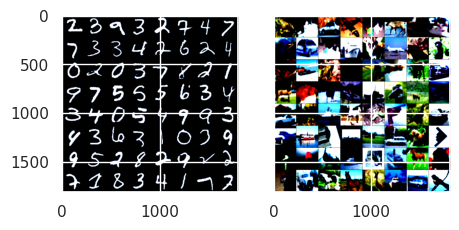

In [45]:
#Get a batch of training data from mnist and cifar
inputsM, classesM = next(iter(dataloaders_mnist['train']))
inputsC, classesC = next(iter(dataloaders_cifar['train']))
imageMax = min(64, BATCH_SIZE)

#Display sample images
imshow(utils.make_grid(inputsM[0:imageMax]), utils.make_grid(inputsC[0:imageMax]))

# 3. Create Model Architectures and Freeze layers

In [46]:
def create_resnet(numClasses):
    #Create base ResNet model
    model_temp = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_fts_temp = model_temp.fc.in_features
    model_temp.fc = torch.nn.Linear(num_fts_temp, numClasses)
    
    #Define loss functions, optimizer and scheduler
    criterion_temp = torch.nn.CrossEntropyLoss()
    optimizer_temp = torch.optim.Adam(model_temp.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_temp, step_size=LR_STEP_SIZE_DECAY, gamma=LR_GAMMA)
    
    return model_temp, {'criterion':criterion_temp, 'optimizer':optimizer_temp, 'scheduler':exp_lr_scheduler}

In [47]:
def create_mobilenet(numClasses):
    #Create base Mobilenet model
    model_temp = models.mobilenet.mobilenet_v2(pretrained=True)
    model_temp.classifier[1] = torch.nn.Linear(in_features=model_temp.classifier[1].in_features,out_features=numClasses)
    
    #Define loss functions, optimizer and scheduler
    criterion_temp = torch.nn.CrossEntropyLoss()
    optimizer_temp = torch.optim.Adam(model_temp.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_temp, step_size=LR_STEP_SIZE_DECAY, gamma=LR_GAMMA)
    
    return model_temp, {'criterion':criterion_temp, 'optimizer':optimizer_temp, 'scheduler':exp_lr_scheduler}

In [48]:
def create_inception(numClasses):
    model_temp = models.inception_v3(pretrained=True)
    # Handle the auxilary net
    num_ftrs = model_temp.AuxLogits.fc.in_features
    model_temp.AuxLogits.fc = torch.nn.Linear(num_ftrs, numClasses)
    # Handle the primary net
    num_ftrs = model_temp.fc.in_features
    model_temp.fc = torch.nn.Linear(num_ftrs,numClasses)
    input_size = 299
    
    #Define loss functions, optimizer and scheduler
    criterion_temp = torch.nn.CrossEntropyLoss()
    optimizer_temp = torch.optim.Adam(model_temp.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_temp, step_size=LR_STEP_SIZE_DECAY, gamma=LR_GAMMA)
    
    return model_temp, {'criterion':criterion_temp, 'optimizer':optimizer_temp, 'scheduler':exp_lr_scheduler}

## 3. Prepare Models for Training

In [49]:
#Add early stop class, inspired by https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [50]:
#Traing method inspired by https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
#modified to fit data structure, and keep trach of metrics accross epochs
def train_model(model, modelDict, dataloaders, num_epochs, noisy=True, epochPatience=2, minDelta=-.001, is_inception=False):
    #get model, criterion, optimizer, scheduler from dictionary 
    since = time.time()
    model = model.to(device) 
    criterion = modelDict['criterion']
    optimizer = modelDict['optimizer']
    scheduler = modelDict['scheduler']

    #Set early stopper parameters
    early_stopper = EarlyStopper(patience=epochPatience, min_delta=minDelta)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_train_acc = 0.0
    
    #Keep track of metrics from training
    metrics = pd.DataFrame(data=[],columns=['epoch','accuracy','loss','phase'])
    
    for epoch in range(num_epochs):
        if noisy:
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 10)

        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  #Set model to training mode
            else:
                model.eval()   #Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #Zero the parameter gradients
                optimizer.zero_grad()

                #Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # backward + optimize for training phase
                    if is_inception and phase=='train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            #Show statistics for each epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset) #dataset_sizes[phase]
            epoch_acc = (running_corrects.double()) / len(dataloaders[phase].dataset) #dataset_sizes[phase]
            
            if noisy:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {min(epoch_acc,1.0):.4f}')
            
            #Track metrics for graphing
            metrics = pd.concat([metrics,pd.DataFrame(data=[[epoch,epoch_acc.item(),epoch_loss,phase]],columns=['epoch','accuracy','loss','phase'])], ignore_index=True)

            #Deep copy the model to keep track of the best one
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc

        if noisy:
            print("")
            
        if early_stopper.early_stop(epoch_loss):
            print("Training stopped on epoch",epoch,"because the loss has not decreased by more than",minDelta,"in",epochPatience,"epochs")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:4f}')
    print(f'Best Train Acc: {min(best_train_acc,1.0):4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

### Example model creation, training

## Build and Train Inception V3

/home/entds.ngisn.com/4j86881/anaconda3/envs/my-torch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/entds.ngisn.com/4j86881/anaconda3/envs/my-torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/5
----------
train Loss: 0.1119 Acc: 0.9739
val Loss: 0.0291 Acc: 0.9913

Epoch 1/5
----------
train Loss: 0.0372 Acc: 0.9916
val Loss: 0.0858 Acc: 0.9773

Epoch 2/5
----------
train Loss: 0.0148 Acc: 0.9967
val Loss: 0.0145 Acc: 0.9954

Epoch 3/5
----------
train Loss: 0.0077 Acc: 0.9985
val Loss: 0.0146 Acc: 0.9960

Epoch 4/5
----------
train Loss: 0.0055 Acc: 0.9989
val Loss: 0.0136 Acc: 0.9961

Epoch 5/5
----------
train Loss: 0.0052 Acc: 0.9992
val Loss: 0.0131 Acc: 0.9963

Training complete in 35m 39s
Best Val Acc: 0.996333
Best Train Acc: 0.999216


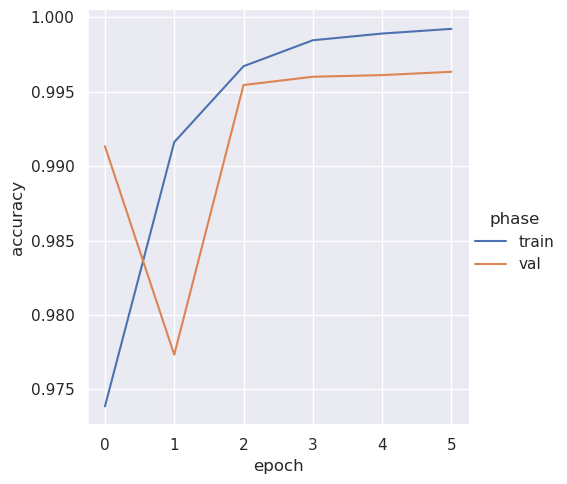

In [20]:
#Create model for dataset
inception_mnist, inception_mnist_dict = create_inception(numClassesMnist)

#Load or train model
modelpath = modelFolderPath + 'model_inception_mnist.pth'
if(os.path.exists(modelpath)):
    inception_mnist.load_state_dict(torch.load(modelpath))
else:
    inception_mnist, metrics_inception_mnist = train_model(inception_mnist, inception_mnist_dict, inception_dataloaders_mnist, EPOCHS,is_inception=True)
    sns.relplot(data=metrics_inception_mnist, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(inception_mnist.state_dict(), modelpath)

/home/entds.ngisn.com/4j86881/anaconda3/envs/my-torch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/entds.ngisn.com/4j86881/anaconda3/envs/my-torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/5
----------
train Loss: 0.5736 Acc: 0.8618
val Loss: 0.4062 Acc: 0.8635

Epoch 1/5
----------
train Loss: 0.2766 Acc: 0.9312
val Loss: 0.4262 Acc: 0.8656

Epoch 2/5
----------
train Loss: 0.0899 Acc: 0.9802
val Loss: 0.1357 Acc: 0.9529

Epoch 3/5
----------
train Loss: 0.0292 Acc: 0.9947
val Loss: 0.1342 Acc: 0.9563

Epoch 4/5
----------
train Loss: 0.0135 Acc: 0.9987
val Loss: 0.1356 Acc: 0.9568

Epoch 5/5
----------
train Loss: 0.0117 Acc: 0.9992
val Loss: 0.1330 Acc: 0.9580

Training complete in 30m 12s
Best Val Acc: 0.958000
Best Train Acc: 0.999176


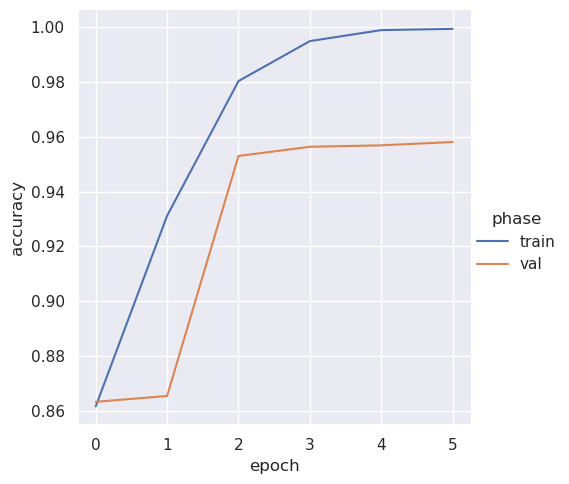

In [21]:
#Create model for dataset
inception_cifar, inception_cifar_dict = create_inception(numClassesCifar)

#Load or train model
modelpath = modelFolderPath + 'model_inception_cifar.pth'
if(os.path.exists(modelpath)):
    inception_cifar.load_state_dict(torch.load(modelpath))
else:
    inception_cifar, metrics_inception_cifar = train_model(inception_cifar, inception_cifar_dict, inception_dataloaders_cifar, EPOCHS,is_inception=True)
    sns.relplot(data=metrics_inception_cifar, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(inception_cifar.state_dict(), modelpath)

## Build and Train MobileNet V2

/home/entds.ngisn.com/4j86881/anaconda3/envs/my-torch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/entds.ngisn.com/4j86881/anaconda3/envs/my-torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/5
----------
train Loss: 0.0777 Acc: 0.9767
val Loss: 0.0352 Acc: 0.9890

Epoch 1/5
----------
train Loss: 0.0270 Acc: 0.9914
val Loss: 0.0418 Acc: 0.9877

Epoch 2/5
----------
train Loss: 0.0100 Acc: 0.9973
val Loss: 0.0165 Acc: 0.9954

Epoch 3/5
----------
train Loss: 0.0058 Acc: 0.9986
val Loss: 0.0152 Acc: 0.9958

Epoch 4/5
----------
train Loss: 0.0044 Acc: 0.9991
val Loss: 0.0146 Acc: 0.9957

Epoch 5/5
----------
train Loss: 0.0042 Acc: 0.9991
val Loss: 0.0151 Acc: 0.9954

Training complete in 12m 49s
Best Val Acc: 0.995778
Best Train Acc: 0.999098


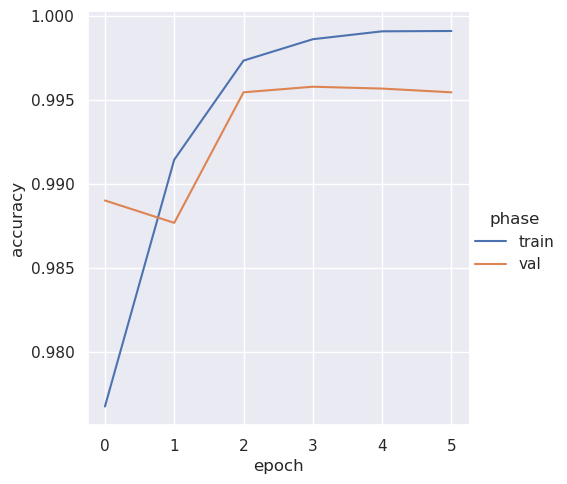

In [22]:
#Create model for dataset
mobilenet_mnist, mobilenet_mnist_dict = create_mobilenet(numClassesMnist)

#Load or train model
modelpath = modelFolderPath + 'model_mobilenet_mnist.pth'
if(os.path.exists(modelpath)):
    mobilenet_mnist.load_state_dict(torch.load(modelpath))
else:
    mobilenet_mnist, metrics_mobilenet_mnist = train_model(mobilenet_mnist, mobilenet_mnist_dict, dataloaders_mnist, EPOCHS)
    sns.relplot(data=metrics_mobilenet_mnist, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(mobilenet_mnist.state_dict(), modelpath)

/home/entds.ngisn.com/4j86881/anaconda3/envs/my-torch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/entds.ngisn.com/4j86881/anaconda3/envs/my-torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/5
----------
train Loss: 0.4249 Acc: 0.8522
val Loss: 0.3003 Acc: 0.8981

Epoch 1/5
----------
train Loss: 0.2035 Acc: 0.9304
val Loss: 0.2778 Acc: 0.9045

Epoch 2/5
----------
train Loss: 0.0769 Acc: 0.9769
val Loss: 0.1685 Acc: 0.9412

Epoch 3/5
----------
train Loss: 0.0363 Acc: 0.9904
val Loss: 0.1675 Acc: 0.9437

Epoch 4/5
----------
train Loss: 0.0209 Acc: 0.9963
val Loss: 0.1626 Acc: 0.9460

Epoch 5/5
----------
train Loss: 0.0192 Acc: 0.9970
val Loss: 0.1634 Acc: 0.9459

Training complete in 11m 10s
Best Val Acc: 0.946000
Best Train Acc: 0.997012


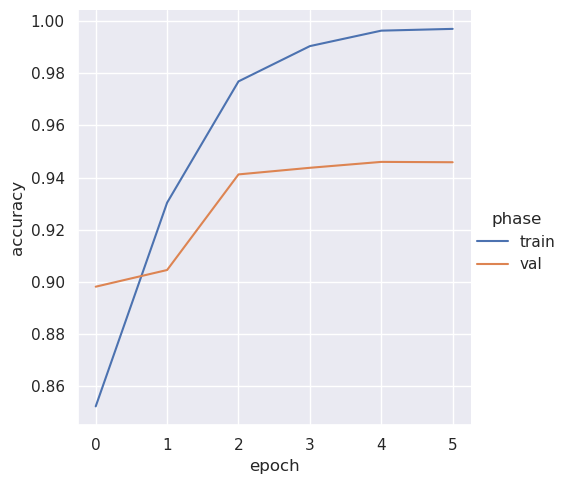

In [23]:
#Create model for dataset
mobilenet_cifar, mobilenet_cifar_dict = create_mobilenet(numClassesCifar)

#Load or train model
modelpath = modelFolderPath + 'model_mobilenet_cifar.pth'
if(os.path.exists(modelpath)):
    mobilenet_cifar.load_state_dict(torch.load(modelpath))
else:
    mobilenet_cifar, metrics_mobilenet_cifar = train_model(mobilenet_cifar, mobilenet_cifar_dict, dataloaders_cifar, EPOCHS)
    sns.relplot(data=metrics_mobilenet_cifar, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(mobilenet_cifar.state_dict(), modelpath)

## Build and Train ResNet-50

Epoch 0/5
----------
train Loss: 0.1054 Acc: 0.9703
val Loss: 0.0493 Acc: 0.9846

Epoch 1/5
----------
train Loss: 0.0291 Acc: 0.9911
val Loss: 0.0398 Acc: 0.9889

Epoch 2/5
----------
train Loss: 0.0090 Acc: 0.9973
val Loss: 0.0153 Acc: 0.9961

Epoch 3/5
----------
train Loss: 0.0043 Acc: 0.9990
val Loss: 0.0150 Acc: 0.9961

Epoch 4/5
----------
train Loss: 0.0029 Acc: 0.9995
val Loss: 0.0148 Acc: 0.9962

Epoch 5/5
----------
train Loss: 0.0027 Acc: 0.9996
val Loss: 0.0148 Acc: 0.9962

Training complete in 24m 6s
Best Val Acc: 0.996222
Best Train Acc: 0.999608


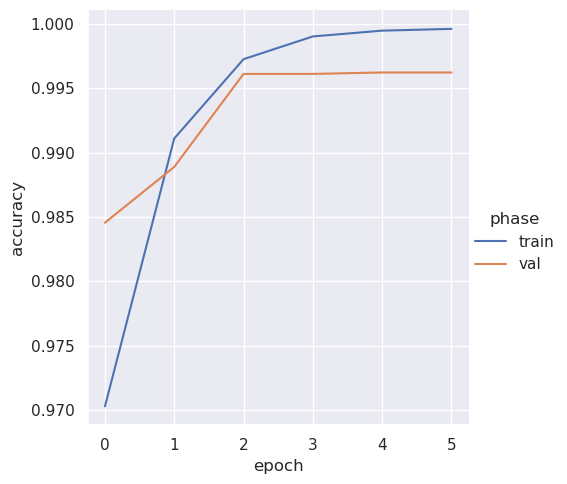

In [58]:
#Create model for dataset
resNet_mnist, resNet_mnist_dict = create_resnet(numClassesMnist)
 
#Load or train model
modelpath = modelFolderPath + 'model_resnet_mnist.pth'
if(os.path.exists(modelpath)):
    resNet_mnist.load_state_dict(torch.load(modelpath))
else:
    resNet_mnist, metrics_resNet_mnist = train_model(resNet_mnist, resNet_mnist_dict, dataloaders_mnist, EPOCHS)
    sns.relplot(data=metrics_resNet_mnist, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(resNet_mnist.state_dict(), modelpath)

Epoch 0/5
----------
train Loss: 0.3906 Acc: 0.8692
val Loss: 0.3073 Acc: 0.8943

Epoch 1/5
----------
train Loss: 0.1674 Acc: 0.9431
val Loss: 0.2655 Acc: 0.9108

Epoch 2/5
----------
train Loss: 0.0486 Acc: 0.9846
val Loss: 0.1331 Acc: 0.9569

Epoch 3/5
----------
train Loss: 0.0111 Acc: 0.9979
val Loss: 0.1368 Acc: 0.9612

Epoch 4/5
----------
train Loss: 0.0045 Acc: 0.9997
val Loss: 0.1380 Acc: 0.9617

Training stopped on epoch 4 because the loss has not decreased by more than -0.001 in 2 epochs
Training complete in 17m 6s
Best Val Acc: 0.961733
Best Train Acc: 0.999671


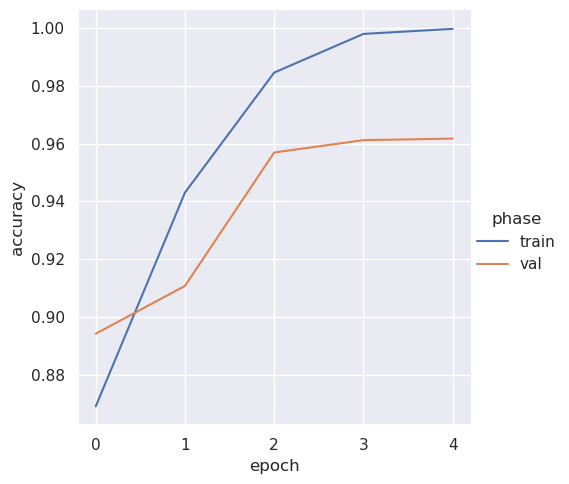

In [59]:
resNet_cifar, resNet_cifar_dict = create_resnet(numClassesCifar)
 
#Load or train model
modelpath = modelFolderPath + 'model_resnet_cifar.pth'
if(os.path.exists(modelpath)):
    resNet_cifar.load_state_dict(torch.load(modelpath))
else:
    resNet_cifar, metrics_resNet_cifar = train_model(resNet_cifar, resNet_cifar_dict, dataloaders_cifar, EPOCHS)
    sns.relplot(data=metrics_resNet_cifar, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(resNet_cifar.state_dict(), modelpath)

## 4.0 Test Base Models

In [51]:
def test_model(model, classes, test_loader):
    torch.cuda.empty_cache()
    #Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model = model.to(device)

    #Store additional prediction info for CF and graphs
    allLabels = []
    allPrediction = []
    testAccuracies = []
    toc = time.time()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
    tic = time.time()
    print(f'Inference Time: {(tic-toc):.4f} s Throughput: {(len(test_loader.dataset)/(tic-toc)):.4f} fps')
    #Collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[label.item()] += 1
            total_pred[label.item()] += 1
            allLabels.append(label.item())
            allPrediction.append(prediction.item())

    #Get each class accuracy manually
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / (total_pred[classname] or 1)
        testAccuracies.append(accuracy)

    #Show overall acurracy
    print(f'Testing Overall Accuracy: {100.0*sum(correct_pred.values())/sum(total_pred.values()):4f} ')
    
    return  allLabels, allPrediction, testAccuracies

In [52]:
#Pass in the 3 metrics from test function, and options to create other graphs
def show_test_results(allLabels, allPrediction, testAccuracies, labelNames, cf=True, bar=True):
    if cf:
        #Show confusion matrix
        cf_matrix = confusion_matrix(allLabels, allPrediction)
        #Divide predicted columns by number predicted for each class
        ax = sns.heatmap((cf_matrix / np.sum(cf_matrix, axis=1)), fmt='.1%', xticklabels=labelNames, yticklabels=labelNames)
        ax.set_xlabel("Predicted Class", fontsize=14, labelpad=20)
        ax.set_ylabel("Labeled Class", fontsize=14, labelpad=20)
        plt.show()
    
    if bar:
        #Format the label data for plotting class accuracies
        uniqueTest, countsTest = np.unique(allLabels, return_counts=True)
        labelDictTest = dict(zip(uniqueTest, countsTest))
        keysTest = list(labelDictTest.keys())
        labelsCountTest = [int(labelDictTest[k]) for k in keysTest]

        #Show class accuracies on barchart
        plot = sns.barplot(x=keysTest, y=testAccuracies)
        plot.set_xticklabels(labels=labelNames, rotation=-45)
        plt.show()

### Example Test Model

In [53]:
allLabels, allPrediction, testAccuracies = test_model(resNet_mnist, classesNumericMnist, dataloaders_mnist['test'])

Inference Time: 11.2301 s Throughput: 890.4623 fps
Testing Overall Accuracy: 100.000000 


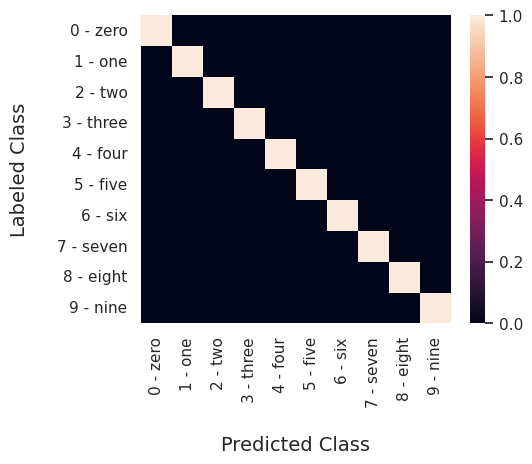

In [54]:
show_test_results(allLabels, allPrediction, testAccuracies, classesMnist, True, False)

In [55]:
allLabels, allPrediction, testAccuracies = test_model(resNet_cifar, classesNumericCifar, dataloaders_cifar['test'])

Inference Time: 10.8166 s Throughput: 924.5045 fps
Testing Overall Accuracy: 100.000000 


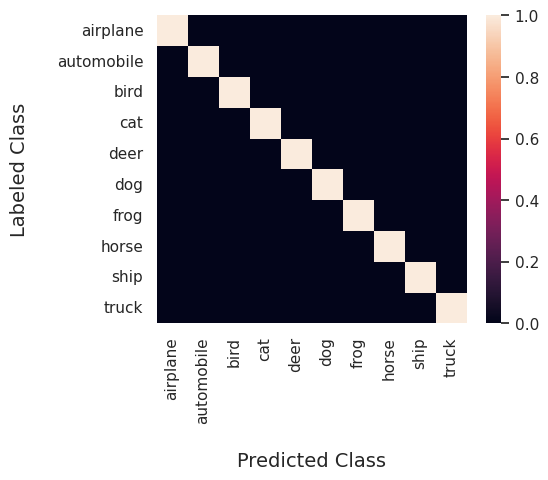

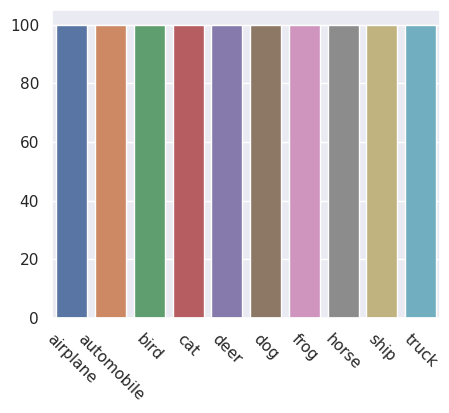

In [56]:
show_test_results(allLabels, allPrediction, testAccuracies, classesCifar, True, True)

### Philip Todo in this section: 
test remaining 4 base models <br>

## 5. Post Training Quantize Models - Philip Todo

## 6. Test Post Training Quantized Models - Philip Todo

# 7. Test Post Quantization Improvement - Paul Todo

We see that mobilenetV2 suffers from accuracy loss after quantization. How can we improve accuracy after quantization? One strategy we can use is analyzing the SQNR of each layer in the network, to understand where the most quantization loss occurs. With this knowledge, we can modify the qconfig_dict settings to skip the problem layers during quantization. 

In [57]:
# Compare weights of float_model and qmodel.
# Note: when comparing weights in models with Conv-BN for PTQ, we need to compare
# weights after Conv-BN fusion for a proper comparison.  Because of this, we use
# `prepared_model` instead of `float_model` when comparing weights.
# Extract conv and linear weights from corresponding parts of two models, and save
# them in `wt_compare_dict`.
mobilenet_wt_compare_dict = ns.extract_weights(
   'fp32',  # string name for model A
   mobilenet_mnist,  # model A
   'int8',  # string name for model B
   mobilenet_mnist_quantized,  # model B
)
# calculate SQNR between each pair of weights
# SQNR is a measure of quantization loss, large SQNR value means the quantization loss is small
ns.extend_logger_results_with_comparison(
   mobilenet_wt_compare_dict,  # results object to modify inplace
   'fp32',  # string name of model A (from previous step)
   'int8',  # string name of model B (from previous step)
   torch.ao.ns.fx.utils.compute_sqnr,  # the function to use to compare two tensors
   'sqnr',  # the name to use to store the results under
)
# massage the data into a format easy to graph and print
# Note: no util function for this since use cases may be different per user
# Note: there is a lot of debugging data, and it will be challenging to print all of it
# and fit on a laptop screen.  It is up to the user to decide which data is useful for them.
mobilenet_wt_to_print = []
for idx, (layer_name, v) in enumerate(mobilenet_wt_compare_dict.items()):
    mobilenet_wt_to_print.append([
        idx,
        layer_name,                                                   
        v['weight']['int8'][0]['prev_node_target_type'],                      
        v['weight']['int8'][0]['values'][0].shape,
        v['weight']['int8'][0]['sqnr'][0],
    ])
    
plt.style.use('seaborn-whitegrid')
# a simple line graph
def plot(xdata, ydata, xlabel, ylabel, title):
    fig = plt.figure(figsize=(10, 5), dpi=100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    ax = plt.axes()
    ax.plot(xdata, ydata)     
# plot the SQNR between fp32 and int8 weights for each layer
# Note: we may explore easier to read charts (bar chart, etc) at a later time, for now
# line chart + table is good enough.
plot([x[0] for x in mobilenet_wt_to_print], [x[4] for x in mobilenet_wt_to_print], 'idx', 'sqnr', 'weights, idx to sqnr')

NameError: name 'mobilenet_mnist_quantized' is not defined